In [1]:
%load_ext autoreload
%autoreload 2

# 1. Synthetic to real domain gap
Take some real image crops from  Sam， with less occlusions，as the templates. And mach them with the raw crops from Sam. You can maybe apply a threshold for the Bounding box size to filter the valid template. See if you can get some reasonable results

## 1.1 Take and save some real image crops from SAM
Take input image then put via sam then choose some of the crops- save in the cnos analysis folder

In [2]:
# load sam
from src.model.sam import CustomSamAutomaticMaskGenerator, load_sam
from segment_anything.modeling.sam import Sam
model_type = "vit_h"
checkpoint_dir =  "datasets/bop23_challenge/pretrained/segment-anything"
sam_model = load_sam(model_type, checkpoint_dir)
custom_sam_model = CustomSamAutomaticMaskGenerator(sam=sam_model)

In [3]:
def move_to_device(segmentor_model, device="cuda:0"):
    # if there is predictor in the model, move it to device
    if hasattr(segmentor_model, "predictor"):
        segmentor_model.predictor.model = (
            segmentor_model.predictor.model.to(device)
        )
    else:
        segmentor_model.model.setup_model(device=device, verbose=True)
move_to_device(custom_sam_model)

In [4]:
from PIL import Image
import torch
import numpy as np
from src.model.utils import Detections
rgb_path = "datasets/bop23_challenge/datasets/icbin/test/000001/rgb/000001.png"
rgb = Image.open(rgb_path).convert("RGB")
detections = custom_sam_model.generate_masks(np.array(rgb))

In [5]:
def extract_object_by_mask(image, mask, width: int = 512):
    mask = Image.fromarray(mask)
    masked_image = Image.composite(
        image, Image.new("RGB", image.size, (0, 0, 0)), mask)
    cropped_image = masked_image.crop(masked_image.getbbox())
    # new_height = width * cropped_image.height // cropped_image.width
    return cropped_image

masked_images = []
for mask in detections["masks"].cpu():
    binary_mask = np.array(mask) * 255
    binary_mask = binary_mask.astype(np.uint8)
    masked_image = extract_object_by_mask(rgb, binary_mask)
    masked_images.append(masked_image)

In [6]:
# Visualize proposals
import matplotlib.pyplot as plt
from math import ceil
def plot_images(images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        ax.imshow(images[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Define the number of rows and columns in the grid
rows = ceil(len(masked_images) / 6)
cols = 6
# Plot the masked_images array in a grid
# plot_images(masked_images, rows, cols) 

In [7]:
# We are choosing proposals 2 and 8
crop1 = {
    "crop" : masked_images[1], # it is saved as Image so crop1["crop"] to visualize it
    "masks" : detections["masks"][1],
    "boxes" : detections["boxes"][1]
}
crop2 = {
    "crop" : masked_images[7],
    "masks" : detections["masks"][7],
    "boxes" : detections["boxes"][7]
}

# save image
crop1["crop"].save("cnos_analysis/crop_proposals/crop1.png")
crop2["crop"].save("cnos_analysis/crop_proposals/crop2.png")

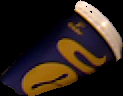

In [8]:
crop2["crop"]

## 1.2 Create and save 42 templates from the test folder using BlenderProc.

In [9]:
# load config file
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose

# Initialize Hydra and compose the configuration
initialize(config_path="configs")
cfg = compose(config_name="run_inference")

/tmp/ipykernel_3355874/1465400466.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="configs")


In [10]:
# 10* set_struct to so that we can add key-value to the file - see lb we add new key-value root_dir to ref_dataloader_config
OmegaConf.set_struct(cfg, False)

In [11]:
default_ref_dataloader_config = cfg.data.reference_dataloader
ref_dataloader_config = default_ref_dataloader_config.copy()
ref_dataloader_config._target_ = "src.dataloader.bop_pbr.BOPTemplatePBR"
ref_dataloader_config.root_dir = "datasets/bop23_challenge/datasets/icbin"
ref_dataloader_config.template_dir += "templates_pyrender/icbin" # we r working on icbin dataset
ref_dataloader_config.templates_output_folder = "cnos_analysis/real_images_templates"


In [12]:
from hydra.utils import instantiate
ref_dataset = instantiate(ref_dataloader_config) # src.dataloader.bop.BOPTemplatePBR
ref_dataset.load_processed_metaData(reset_metaData=True)

INFO:lightning_lite.utilities.seed:Global seed set to 2023
INFO:lightning_lite.utilities.seed:Global seed set to 2023
Loading metaData: 100%|██████████| 3/3 [00:00<00:00, 150.25it/s]
Finding nearest rendering close to template poses: 100%|██████████| 2/2 [00:00<00:00, 286.75it/s]


In [13]:
import pandas as pd
# cnos_analysis/test_processed_metaData.csv has size of 84 templates for 2 models# cnos_analysis/test_metaData.csv is has size of 2250 tempaltes - it is before we choose 42 templates for each
templates = pd.read_csv("cnos_analysis/test_processed_metaData.csv")

In [14]:
# Save templates as images
from torchvision.utils import save_image
import os
for ob_id in range(1,len(templates)//42+1):
    obj_id_path = os.path.join("cnos_analysis/real_images_templates/icbin", f'obj_{(ob_id):06d}') ## achtung 06d not just 6d
    if not os.path.exists(obj_id_path):
        os.makedirs(obj_id_path)
    for i, img in enumerate(ref_dataset[ob_id-1]["templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
        save_image(img, os.path.join(obj_id_path, f'{i:06d}.png'))


## 1.3 Extract feature descriptors for the 42 templates
Using Dinov2  

In [15]:
# define the cnos model
cfg_segmentor = cfg.model.segmentor_model
if "fast_sam" in cfg_segmentor._target_:
    logging.info("Using FastSAM, ignore stability_score_thresh!")
else:
    cfg.model.segmentor_model.stability_score_thresh = 0.97 # for sam

model = instantiate(cfg.model).to("cuda")

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [16]:
model.device

device(type='cuda', index=0)

In [17]:
import glob
import logging
from src.utils.bbox_utils import CropResizePad
# can also put the tranform for the image before going via Dino - but actually I tested that and it is actually the same

template_dir = "cnos_analysis/real_images_templates/icbin/obj_000001"
template_paths = glob.glob(f"{template_dir}/*.png")
boxes, templates = [], []
for path in template_paths:
    image = Image.open(path)
    boxes.append(image.getbbox())
    image = torch.from_numpy(np.array(image.convert("RGB")) / 255).float() # convert templates in format of Image to np then devide them by 255
    templates.append(image)
    
templates = torch.stack(templates).permute(0, 3, 1, 2) # now qw have a stack of 42,3,480*640
boxes = torch.tensor(np.array(boxes))

processing_config = OmegaConf.create(
    {
        "image_size": 224,
    }
)
proposal_processor = CropResizePad(processing_config.image_size)
templates = proposal_processor(images=templates, boxes=boxes).cuda() # here resize the templates to size of 42,3,224,224 I assume
save_image(templates, f"{template_dir}/cnos_results/templates.png", nrow=7) # here just put all templates in 1 image and save it
ref_features = model.descriptor_model.compute_features(
                templates, token_name="x_norm_clstoken"
            ) # extract features for the 42 templates - obtain shape as 42,1024
logging.info(f"Ref feats: {ref_features.shape}")

In [18]:
ref_features.shape

torch.Size([42, 1024])

## 1.5 Extract features from the crop
Scale and pad the crops to size of (224,224) before going through Dinov2

In [19]:
crop_rgb = np.array(Image.open("cnos_analysis/crop_proposals/crop1.png").convert("RGB")) # (124, 157, 3)

In [20]:
import torchvision.transforms as T
# Use the normalize tranformation means we also use the normalized templates as well - 10*
rgb_normalize = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

In [21]:
import torch.nn.functional as F
normalized_crop_rgb = rgb_normalize(crop_rgb).float()


In [22]:
# Scale image to 224
target_max = 224
scale_factor = target_max / torch.max(torch.tensor(normalized_crop_rgb.shape)) # 224/max of x1,y1,x2,y2
scaled_crop_rgb = F.interpolate(normalized_crop_rgb.unsqueeze(0), scale_factor=scale_factor.item())[0] # Shape [3, 176, 224])

In [23]:
# Padding 0 to 3,224,224
original_h, original_w = scaled_crop_rgb.shape[1:]
original_ratio = original_w / original_h
target_h, target_w = 224, 224
target_ratio  = target_w/target_h 
if  target_ratio != original_ratio: 
    padding_top = max((target_h - original_h) // 2, 0)
    padding_bottom = target_h - original_h - padding_top
    padding_left = max((target_w - original_w) // 2, 0)
    padding_right = target_w - original_w - padding_left
    scaled_padded_crop_rgb = F.pad(
    scaled_crop_rgb, (padding_left, padding_right, padding_top, padding_bottom)
    )
scaled_padded_crop_rgb = scaled_padded_crop_rgb.unsqueeze(0) # unsqueeze to make it as a stack of proposals - here we use only 1 proposals
scaled_padded_crop_rgb.shape # Should be 3,224,224 - if not then do line 122 in src/utils/bbox_utils.py

torch.Size([1, 3, 224, 224])

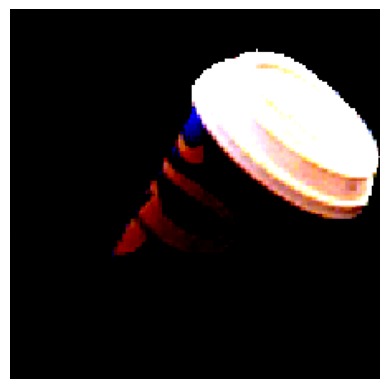

In [24]:
# Display the image - 10* see lb the crop is normalized same way as the templates- ready to compare the similarity now
plt.imshow(scaled_padded_crop_rgb[0].permute(1,2,0))
plt.axis('off')  # Optional: Turn off the axis
plt.show()

In [25]:
# Extract feature
feature_decriptors = model.descriptor_model.forward_by_chunk(scaled_padded_crop_rgb.to("cuda"))
# Forward_by_chunk cos we already process all the prosals that we get the processed_rgbs = scaled_padded_crop_rgb from previous steps already
feature_decriptors.shape

torch.Size([1, 1024])

## 1.4 Calculate the similarity 
Now we have feature_descriptors and reference_descriptors, we can compute simlarity between reference discriptors(from templates) and features descriptors(from input image) and get the top 5 most similar templates to the crop



In [26]:
from src.model.loss import PairwiseSimilarity, Similarity
metric = Similarity() # cnos  uses PairwiseSimilariy - what is the difference between Similarity and Pairwise Similarity ?

In [27]:
# get scores per proposal
scores = metric(feature_decriptors[:, None, :], ref_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_prosals*num_templates instead
score_per_detection, similar_template_indices = torch.topk(scores, k=5, dim=-1) # get top 5 most similar templates
score_per_detection = torch.mean(
    score_per_detection, dim=-1
) # get the final confidence score

In [40]:
# Check the confidence scores for the similar templates
similar_scores = scores[:, similar_template_indices[0].to("cpu")]
similar_scores

tensor([[0.7206, 0.6810, 0.6584, 0.6573, 0.6523]], device='cuda:0')

In [49]:
from torchvision.io import read_image
similar_templates = []
for i in range(len(similar_template_indices[0])):
    img = read_image(f"cnos_analysis/real_images_templates/icbin/obj_000001/{(similar_template_indices[0][i]):06d}.png")
    similar_templates.append(img)
tempplate_images = torch.stack(similar_templates)

In [50]:
save_image(tempplate_images, "cnos_analysis/real_images_templates/top_5_templates.png")

RuntimeError: result type Float can't be cast to the desired output type Byte

# 2. Scale
Try to zoom in and zoom out the templates or real image crops for the Sam instance， see if the similarly score changes

# 3. Occlusion
Find a real image crop without occlusion， and maskout some area of it，see how much the similarly score decrease